In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.pyaudio_helper as pah
import scipy.signal as signal
import time
import sys
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# Introduction 
Without getting too detailed Lab is about a simple technique for either increasing or decreasing the playing time of a sound array, without altering the sound's pitch. Increasing the rate refers to decreasing the playing time, while decreasing the rate implies increasing the playing time. Both operations can be solved in an approximate way by *butt splicing* speech segments of say 45 ms or so. Butt splicing in DSP is analogous to adding or removing segments of magnetic recording tape by end-to-end taping them together to form a new edited tape. Butt splicing of speech sequences thus implies that no transition smoothing is used, just a hard end-to-end connection.

To make a recording of your own speech you will use `PyAudio` via the module `pyaudio_helper`. The configuration of PyAudio currently implemented in `pyaudio_helper` is single channel input/output (I/O) using a *callback* function. The callback function insure that the audio processing in *non-blocking* relative to other operations the PC might be trying to deal with, e.g., responding to mouse moves, etc.

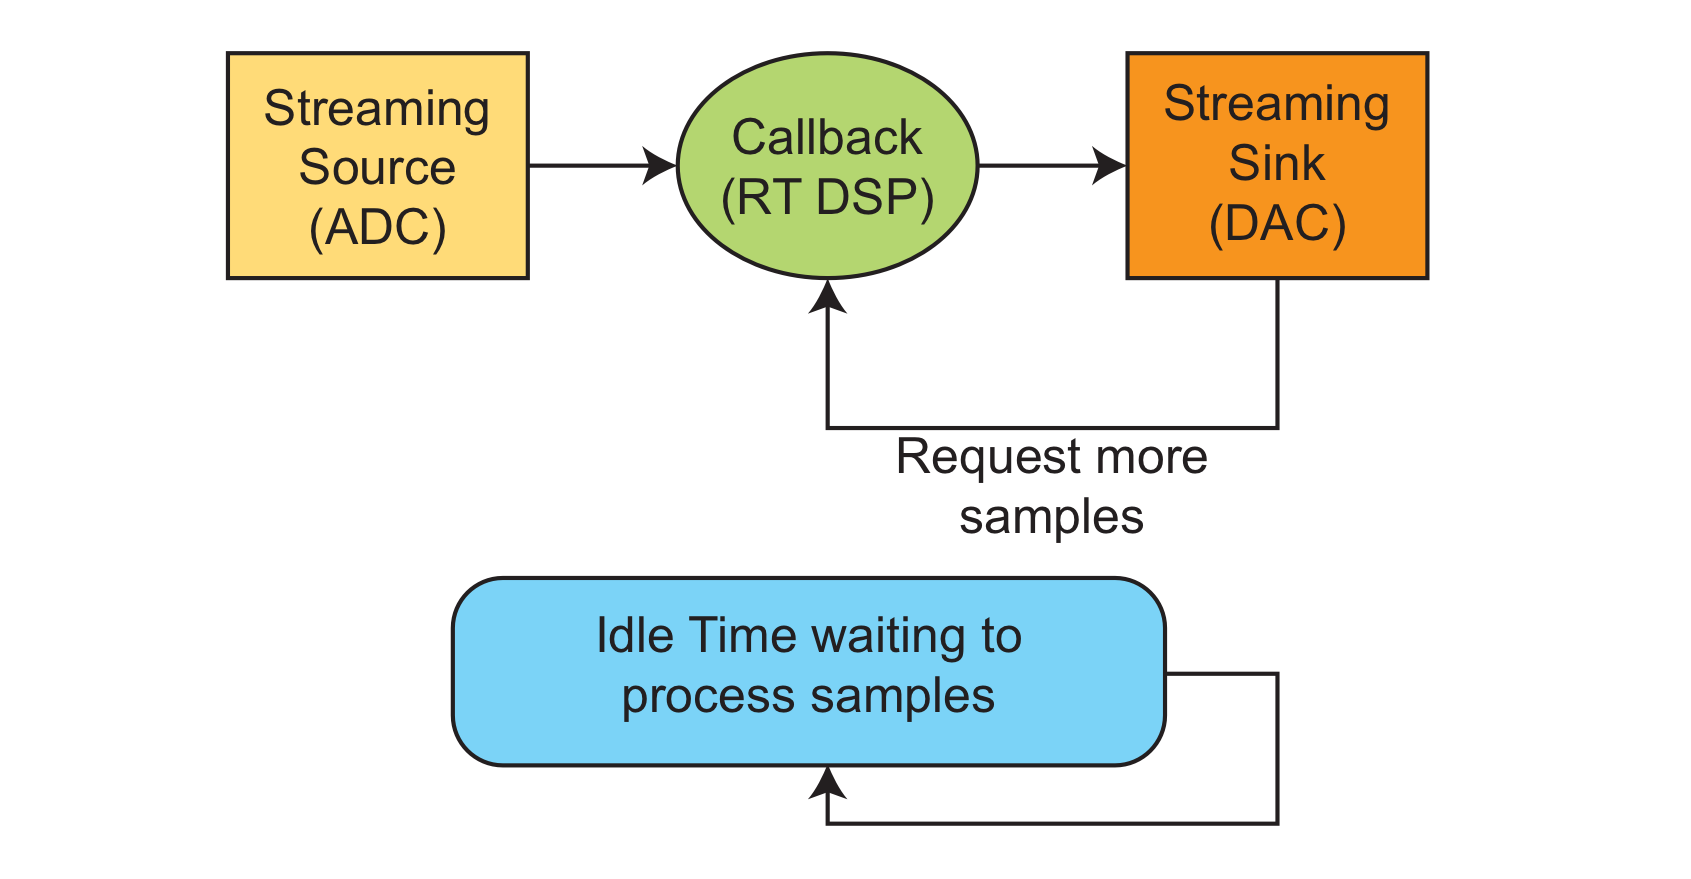

In [5]:
Image('images/PyAudio_RT_flow@300dpi.png',width='80%')

In [4]:
pah.available_devices()

Index 0 device name = Built-in Microphone, inputs = 2, outputs = 0
Index 1 device name = Built-in Output, inputs = 0, outputs = 2
Index 2 device name = HDMI, inputs = 0, outputs = 2
Index 3 device name = USB Audio Device, inputs = 1, outputs = 2


# Begin by Making a Short Audio Clip
Make a simple recording to capture some speech for further processing.

In [5]:
# Here we configure the callback to capture a one channel input
def callback(in_data, frame_count, time_info, status):
    # convert byte data to ndarray
    in_data_nda = np.fromstring(in_data, dtype=np.int16)
    x = in_data_nda.astype(float32)
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(x)
    # The 0 below avoids unwanted feedback to your speakers (we are just capturing)
    return ((0*x).astype(int16)).tobytes(), pah.pyaudio.paContinue

In [23]:
# FYI, the ms per speech frame
1024/8000*1000

128.0

In [6]:
#pah.DSP_io_stream(stream_callback, <== the name of the callback function
#                  in_idx=1, out_idx=4, <== valid input and output devices
#                  frame_length=1024, <== length of the frame in samples
#                  fs=44100, <== the sampling rate
#                  Tcapture=0, <== capture buffer length in s; 0 --> 'infinite'
#                  sleep_time=0.1) <== sleep time for the 'while loop'
DSP_IO = pah.DSP_io_stream(callback,0,1,fs=8000)
DSP_IO.stream(5)

Audio input/output streaming session complete!


## Playback Using the `Audio` Control
Playback your recording or optionally load a saved `.wav` file, such as `speech.wav`.

In [7]:
# Save your recording to a wave file from the data capture buffer
ss.to_wav('my_speech.wav',8000,DSP_IO.data_capture/max(DSP_IO.data_capture))
# If need be reload it into array x
#fs, x = ss.from_wav('my_speech.wav')
Audio('my_speech.wav')

In [8]:
# Load one of several 8 ksps speech files
fs, x = ss.from_wav('speech.wav')
Audio('speech.wav')

# Playback and Loop the Recording
Using the PyAudio interface you can turn around and play an array to an audio output device. e.g., your PC speakers. Optionally you can take the array and create a *looped array* that repeat itself assuming the original length is less than the output stream time. First load an array from a wave file, define an output stream callback, create a `loop_audio()` object, create a `DSP_io()` stream object, and finally call the `stream()` method providing a play time in s.

In [9]:
fs, x = ss.from_wav('speech.wav')

In [10]:
# Here we configure the callback to play back a wav file                    
def callback2(in_data, frame_count, time_info, status):
    global x_loop
    # Note wav is scaled to [-1,1] so need to rescale to int16
    y = 32767*x_loop.get_samples(frame_count)
    DSP_IO.DSP_capture_add_samples(y)
    # Convert from float back to int16
    y = y.astype(int16)
    return y.tobytes(), pah.pyaudio.paContinue

In [11]:
x_loop = pah.loop_audio(x)
DSP_IO = pah.DSP_io_stream(callback2,0,1,fs=8000,Tcapture=1)
DSP_IO.stream(5)

Audio input/output streaming session complete!


## Develop the Decrease Playback Time Code Here
The objective is decrease the playback time by a factor of 2 without pitch shifting. To decrease the playback time, yet retain the proper pitch, all we need do is to periodically remove short segments of the original speech vector, butt splice the remaining pieces back together, then play it back at the original recording rate. If the pattern is save 45 ms, discard 45 ms, save 45 ms, etc., the new sound vector will be half as long as the original, thus it will play in half the time. A graphical description of the operation in terms of Python ndarrays is shown below.

The segment length may need to be adjusted for best sound quality. Note I recommend the option order=’F’, that is column-major ordering as found in Fortran arrays, is taken in the reshape.

* **Note**: A parameter you must choose is the length of the sub-segments, call it $N_\text{sub}$
* The playback speech quality is affected by $N_\text{sub}$

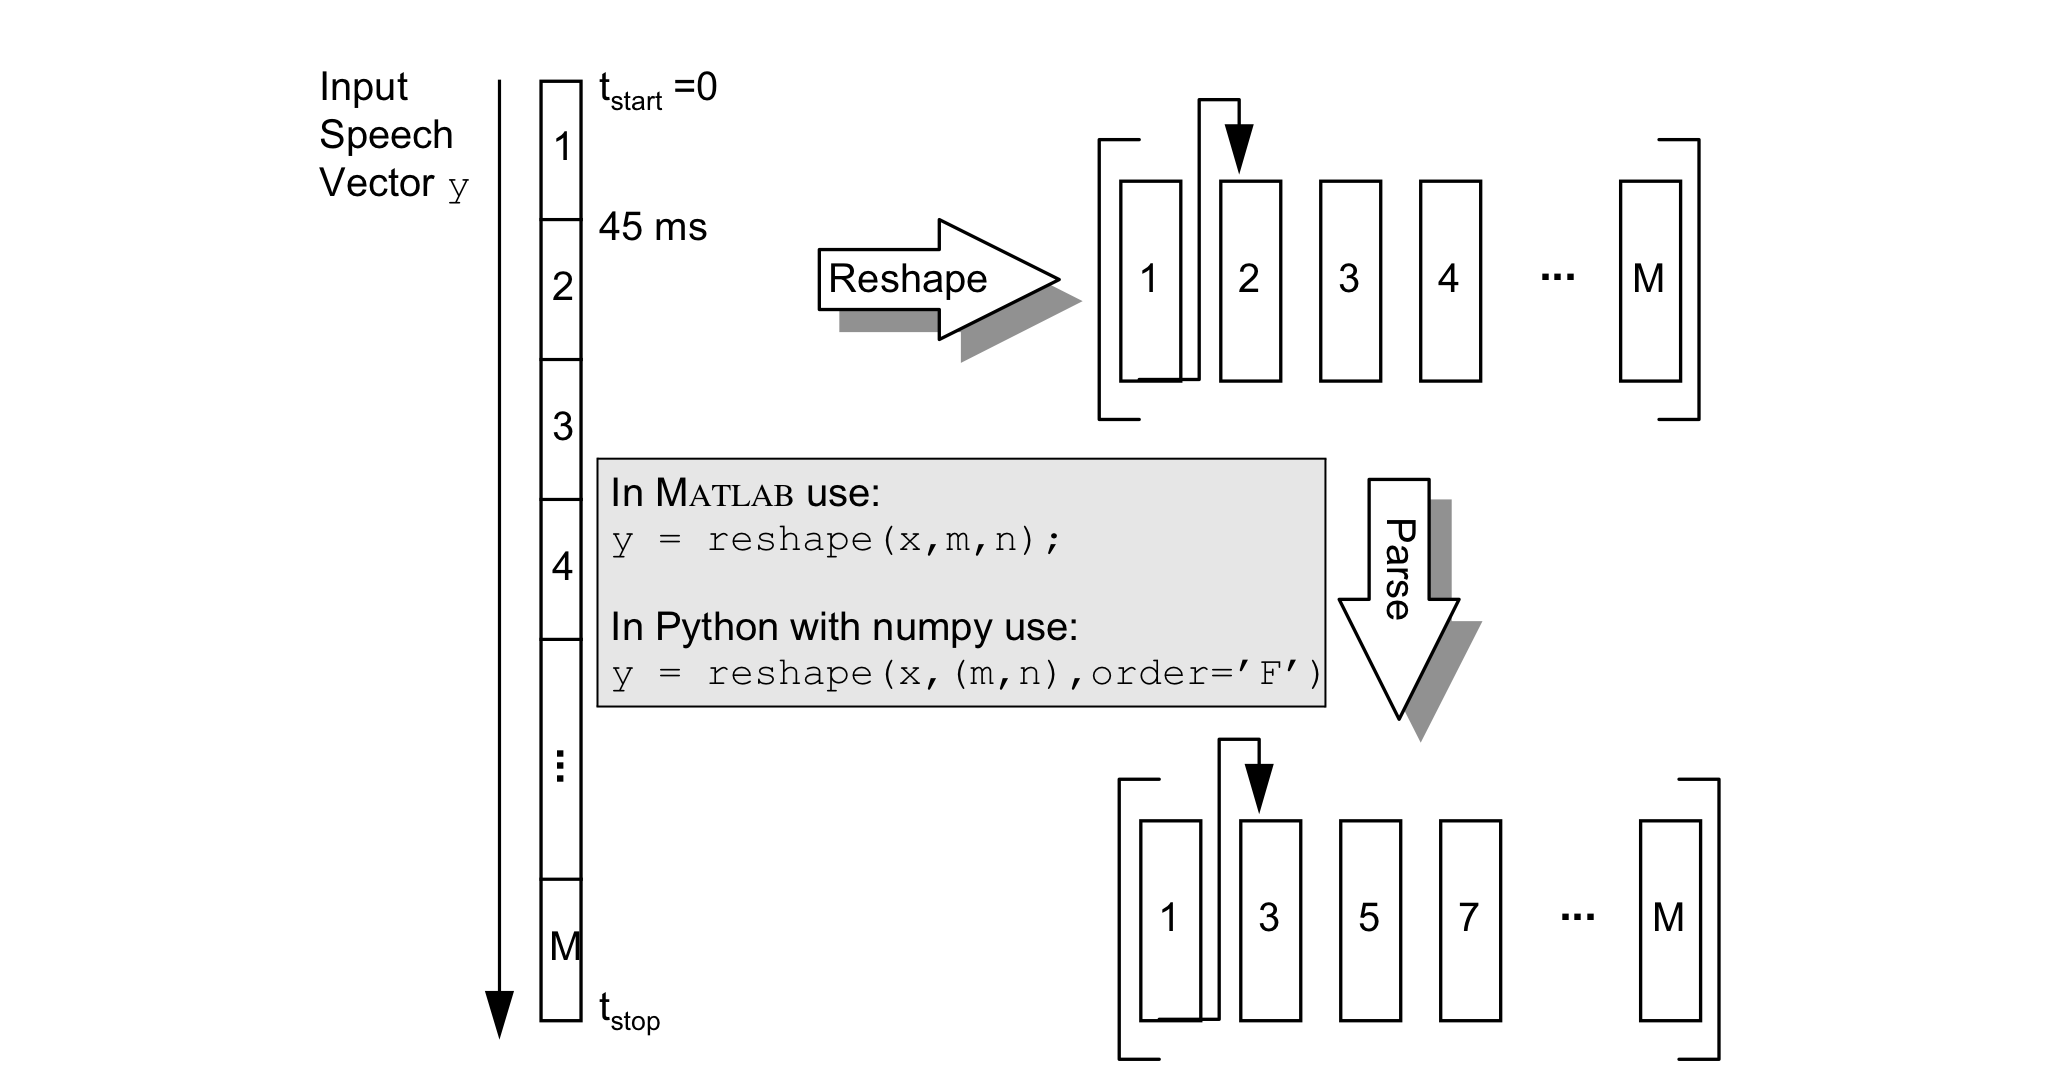

In [8]:
Image('images/Speed_Up_Speech.png',width='80%')

#### Hints

In [11]:
s = arange(0,16)
s

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [13]:
# Consider N_sub = 2
sr = reshape(s,(2,8),order='C')
sr

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [12]:
# Consider N_sub = 2
sr = reshape(s,(2,8),order='F')
sr

array([[ 0,  2,  4,  6,  8, 10, 12, 14],
       [ 1,  3,  5,  7,  9, 11, 13, 15]])

In [29]:
srd = sr[:,::2]
srd

array([[ 0,  4,  8, 12],
       [ 1,  5,  9, 13]])

In [34]:
srdo = reshape(srd,(1,len(s)//2),order='F')
srdo

array([[ 0,  1,  4,  5,  8,  9, 12, 13]])

Eventually playback (class solution)

In [12]:
Nx = len(x)
Nsub = 400
Nxt = Nsub*int(Nx/Nsub)
Nxt
xr = reshape(x,(Nsub,int(Nxt/Nsub)),order='F')
xrd = xr[:,::2]
xrd0 = reshape(xrd,(1,xrd.shape[0]*xrd.shape[1]),order='F')
ss.to_wav('speed_up.wav',fs,xrd0.flatten())
Audio('speed_up.wav')

## Develop the Increase Playback Time Code Here
The objective is increase the playback time by a factor of 2 without pitch shifting. To increase the playback time, yet retain the proper pitch, all we need do is to periodically repeat short segments of the original speech vector, again using a butt splicing technique, then play it back at the original recording rate. If the pattern is say 45 ms, repeat previous 45 ms, save next 45 ms, etc., the new sound vector will be twice as long as the original, thus it will play in twice the time.

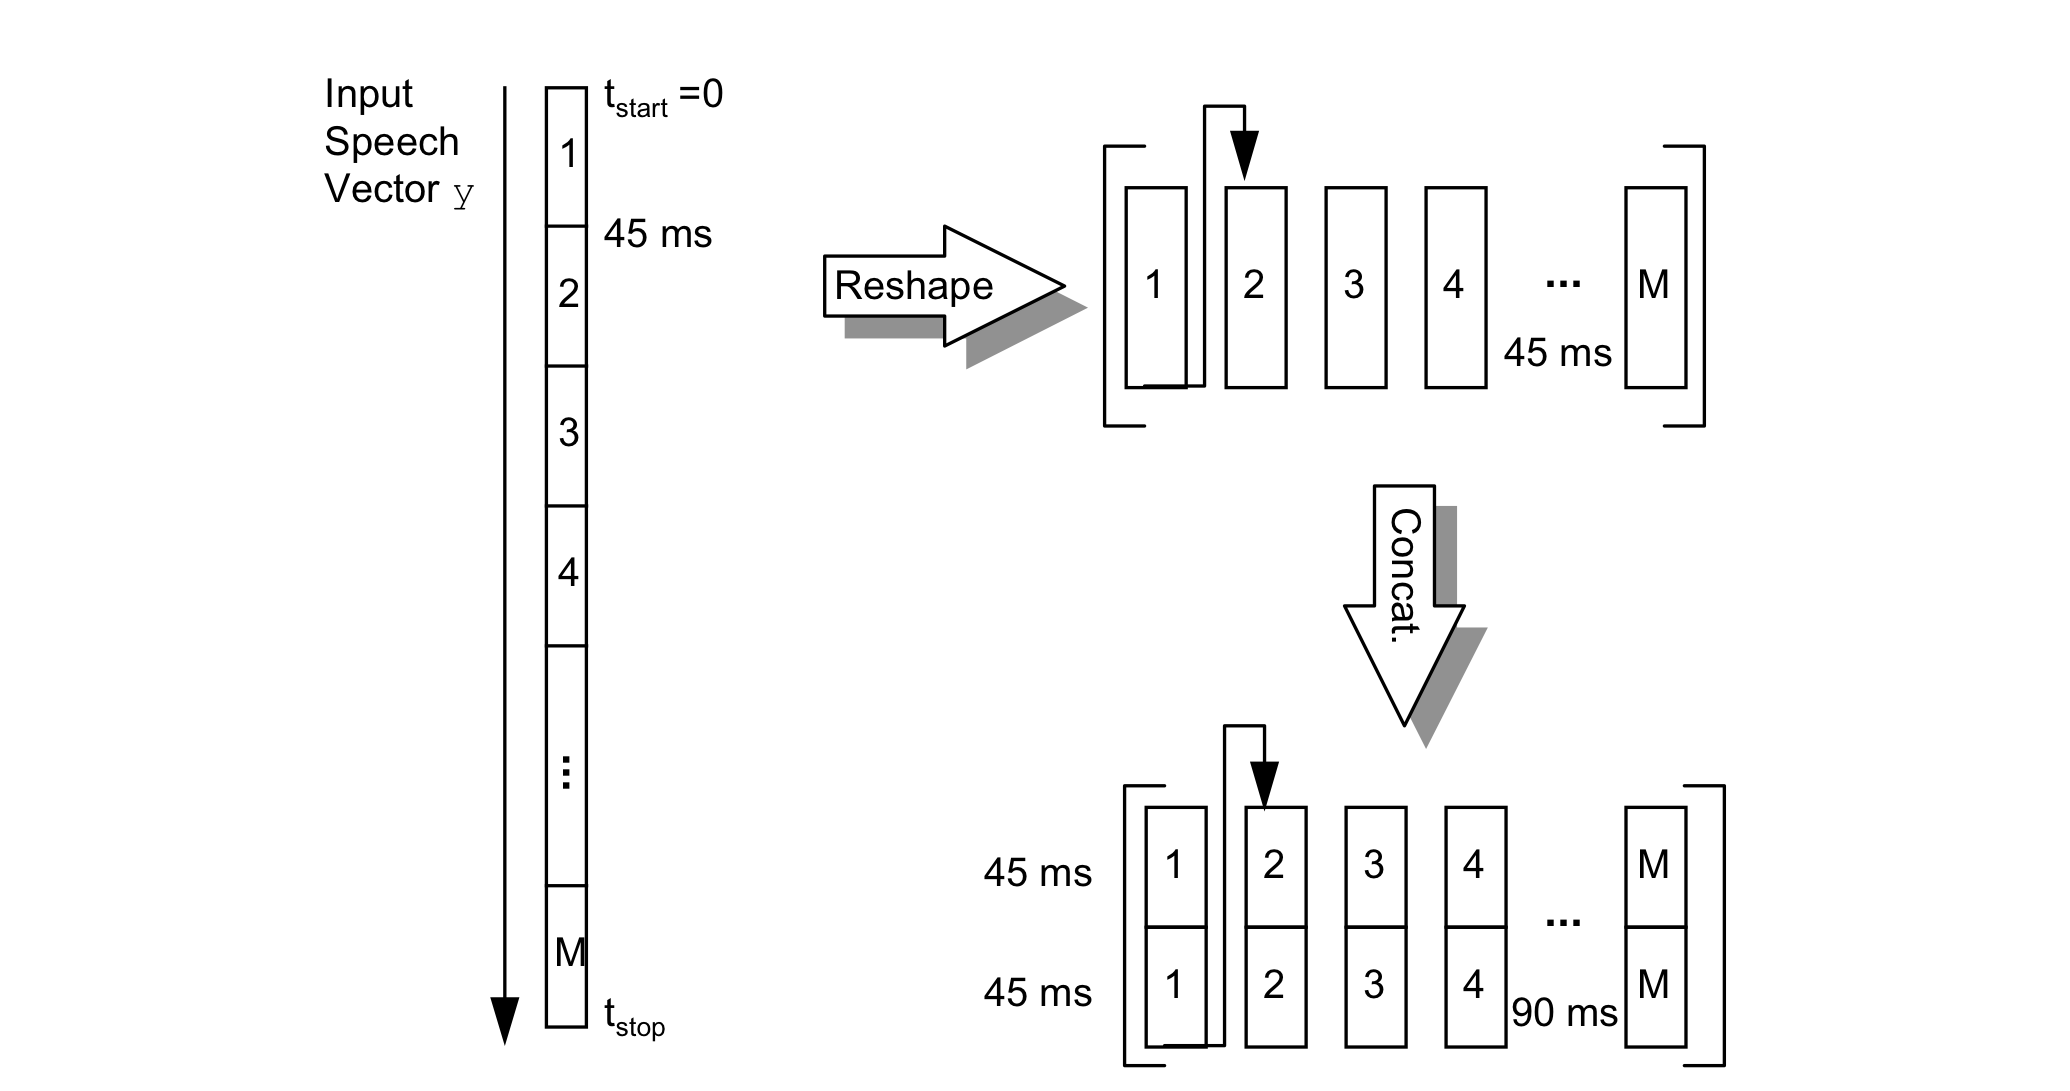

In [9]:
Image('images/Slow_Down_Speech.png',width='80%')

#### Hints

In [32]:
s = arange(0,16)
sru = reshape(s,(2,8),order='F')
sru

array([[ 0,  2,  4,  6,  8, 10, 12, 14],
       [ 1,  3,  5,  7,  9, 11, 13, 15]])

In [35]:
srus = vstack((sru,sru))
srus

array([[ 0,  2,  4,  6,  8, 10, 12, 14],
       [ 1,  3,  5,  7,  9, 11, 13, 15],
       [ 0,  2,  4,  6,  8, 10, 12, 14],
       [ 1,  3,  5,  7,  9, 11, 13, 15]])

In [37]:
sruso = reshape(srus,(1,len(s)*2),order='F')
sruso

array([[ 0,  1,  0,  1,  2,  3,  2,  3,  4,  5,  4,  5,  6,  7,  6,  7,  8,
         9,  8,  9, 10, 11, 10, 11, 12, 13, 12, 13, 14, 15, 14, 15]])

Eventually playback (class solution)

In [13]:
Nx = len(x)
Nsub = 200
Nxt = Nsub*int(Nx/Nsub)
Nxt
xr = reshape(x,(Nsub,int(Nxt/Nsub)),order='F')
xrd = vstack((xr,xr))
xrd0 = reshape(xrd,(1,xrd.shape[0]*xrd.shape[1]),order='F')
ss.to_wav('slow_dn.wav',fs,xrd0.flatten())
Audio('slow_dn.wav')